Sage attention seems to have really significant error for the SM 9.0 version. This happens to the latest main branch, and latest released 2.2.0 version.

In [1]:
%cd /home/ubuntu/Qwen-Image-Edit-Angles

/home/ubuntu/Qwen-Image-Edit-Angles


In [2]:
#!/usr/bin/env python3
import torch
import torch.nn.functional as F
from torch.nn.attention import SDPBackend, sdpa_kernel
from sageattention import (
    sageattn_qk_int8_pv_fp16_cuda, 
    sageattn_qk_int8_pv_fp16_triton, 
    sageattn_qk_int8_pv_fp8_cuda, 
    sageattn_qk_int8_pv_fp8_cuda_sm90
)
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict


def calculate_tolerance_metrics(actual, expect):
    """Calculate tolerance metrics between actual and expected outputs."""
    actual = actual.float()
    expect = expect.float()
    diff = (actual - expect).abs()
    eps = torch.tensor(
        torch.finfo(actual.dtype).eps, device=actual.device, dtype=actual.dtype
    )
    rdiff = diff / torch.maximum(torch.maximum(actual.abs(), expect.abs()), eps)
    return {
        "mean_relative_tolerance": rdiff.mean().item(),
        "max_relative_tolerance": rdiff.max().item(),
        "mean_absolute_tolerance": diff.mean().item(),
        "max_absolute_tolerance": diff.max().item(),
        "mse": F.mse_loss(actual, expect).item()
    }


# Test configuration
batch_size = 4
head_num = 32
seq_len = 64
head_dim = 128
dtype = torch.float16
num_inputs = 100

print(f"Running tests with {num_inputs} inputs...")
print(f"Config: batch_size={batch_size}, head_num={head_num}, seq_len={seq_len}, head_dim={head_dim}, dtype={dtype}")
print("-" * 80)

# Define attention implementations to test
attention_types = {
    "SDPA (Flash)": lambda q, k, v: F.scaled_dot_product_attention(q, k, v),
    "SageAttn QK-INT8 PV-FP16 CUDA": sageattn_qk_int8_pv_fp16_cuda,
    "SageAttn QK-INT8 PV-FP16 Triton": sageattn_qk_int8_pv_fp16_triton,
    "SageAttn QK-INT8 PV-FP8 CUDA": sageattn_qk_int8_pv_fp8_cuda,
    "SageAttn QK-INT8 PV-FP8 CUDA SM90": sageattn_qk_int8_pv_fp8_cuda_sm90,
}

# Storage for metrics across all inputs
all_metrics = {name: defaultdict(list) for name in attention_types.keys()}

# Enable math backend for ground truth
torch.backends.cuda.enable_math_sdp(True)

# Run tests for 100 inputs
for i in range(num_inputs):
    # Generate random input
    q = torch.randn(batch_size, head_num, seq_len, head_dim, device="cuda", dtype=dtype)
    k = torch.randn_like(q)
    v = torch.randn_like(q)
    
    # Get ground truth using mathematically correct implementation
    with sdpa_kernel(SDPBackend.MATH):
        out_math = F.scaled_dot_product_attention(q, k, v)
    
    # Test each attention type
    for name, attn_fn in attention_types.items():
        try:
            if name == "SDPA (Flash)":
                with sdpa_kernel(SDPBackend.FLASH_ATTENTION):
                    out = attn_fn(q, k, v)
            else:
                out = attn_fn(q, k, v)
            
            # Calculate metrics
            metrics = calculate_tolerance_metrics(out, out_math)
            
            # Store metrics
            for metric_name, value in metrics.items():
                all_metrics[name][metric_name].append(value)
                
        except Exception as e:
            print(f"Error with {name}: {e}")
    
    if (i + 1) % 20 == 0:
        print(f"Completed {i + 1}/{num_inputs} inputs...")

print(f"\nCompleted all {num_inputs} inputs!")
print("=" * 80)





Running tests with 100 inputs...
Config: batch_size=4, head_num=32, seq_len=64, head_dim=128, dtype=torch.float16
--------------------------------------------------------------------------------
Completed 20/100 inputs...
Completed 40/100 inputs...
Completed 60/100 inputs...
Completed 80/100 inputs...
Completed 100/100 inputs...

Completed all 100 inputs!


In [3]:
# Calculate mean metrics across all inputs
mean_metrics = {}
for name in attention_types.keys():
    mean_metrics[name] = {
        metric: np.mean(all_metrics[name][metric]) 
        for metric in all_metrics[name].keys()
    }


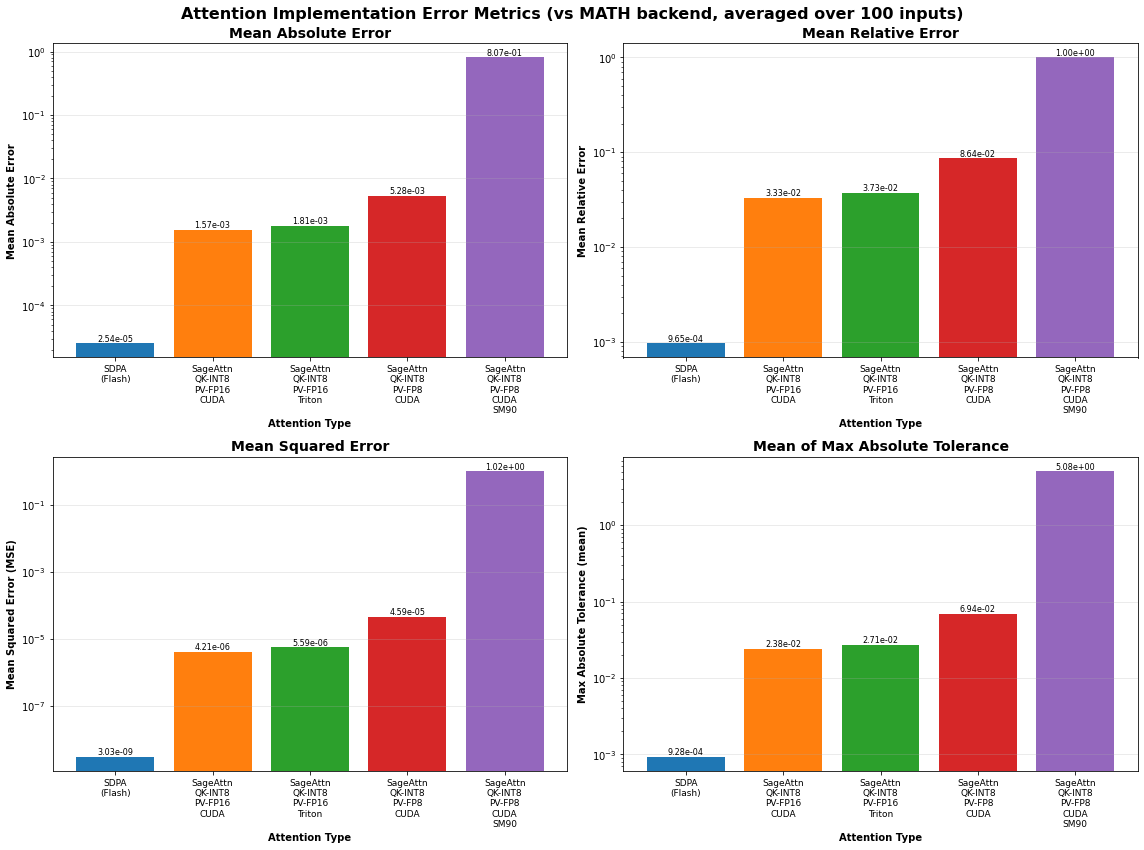

Barplots generated successfully!


In [4]:
# Create barplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Attention Implementation Error Metrics (vs MATH backend, averaged over 100 inputs)', 
             fontsize=16, fontweight='bold')

# Prepare data for plotting
names = list(mean_metrics.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Metric 1: Mean Absolute Error
ax1 = axes[0, 0]
mean_abs_errors = [mean_metrics[name]['mean_absolute_tolerance'] for name in names]
bars1 = ax1.bar(range(len(names)), mean_abs_errors, color=colors)
ax1.set_xlabel('Attention Type', fontweight='bold')
ax1.set_ylabel('Mean Absolute Error', fontweight='bold')
ax1.set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax1.grid(axis='y', alpha=0.3)
ax1.set_yscale('log')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, mean_abs_errors)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 2: Mean Relative Error
ax2 = axes[0, 1]
mean_rel_errors = [mean_metrics[name]['mean_relative_tolerance'] for name in names]
bars2 = ax2.bar(range(len(names)), mean_rel_errors, color=colors)
ax2.set_xlabel('Attention Type', fontweight='bold')
ax2.set_ylabel('Mean Relative Error', fontweight='bold')
ax2.set_title('Mean Relative Error', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
ax2.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars2, mean_rel_errors)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 3: MSE
ax3 = axes[1, 0]
mse_values = [mean_metrics[name]['mse'] for name in names]
bars3 = ax3.bar(range(len(names)), mse_values, color=colors)
ax3.set_xlabel('Attention Type', fontweight='bold')
ax3.set_ylabel('Mean Squared Error (MSE)', fontweight='bold')
ax3.set_title('Mean Squared Error', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars3, mse_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 4: Max Absolute Tolerance
ax4 = axes[1, 1]
max_abs_tolerance = [mean_metrics[name]['max_absolute_tolerance'] for name in names]
bars4 = ax4.bar(range(len(names)), max_abs_tolerance, color=colors)
ax4.set_xlabel('Attention Type', fontweight='bold')
ax4.set_ylabel('Max Absolute Tolerance (mean)', fontweight='bold')
ax4.set_title('Mean of Max Absolute Tolerance', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(names)))
ax4.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax4.grid(axis='y', alpha=0.3)
ax4.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars4, max_abs_tolerance)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Barplots generated successfully!")


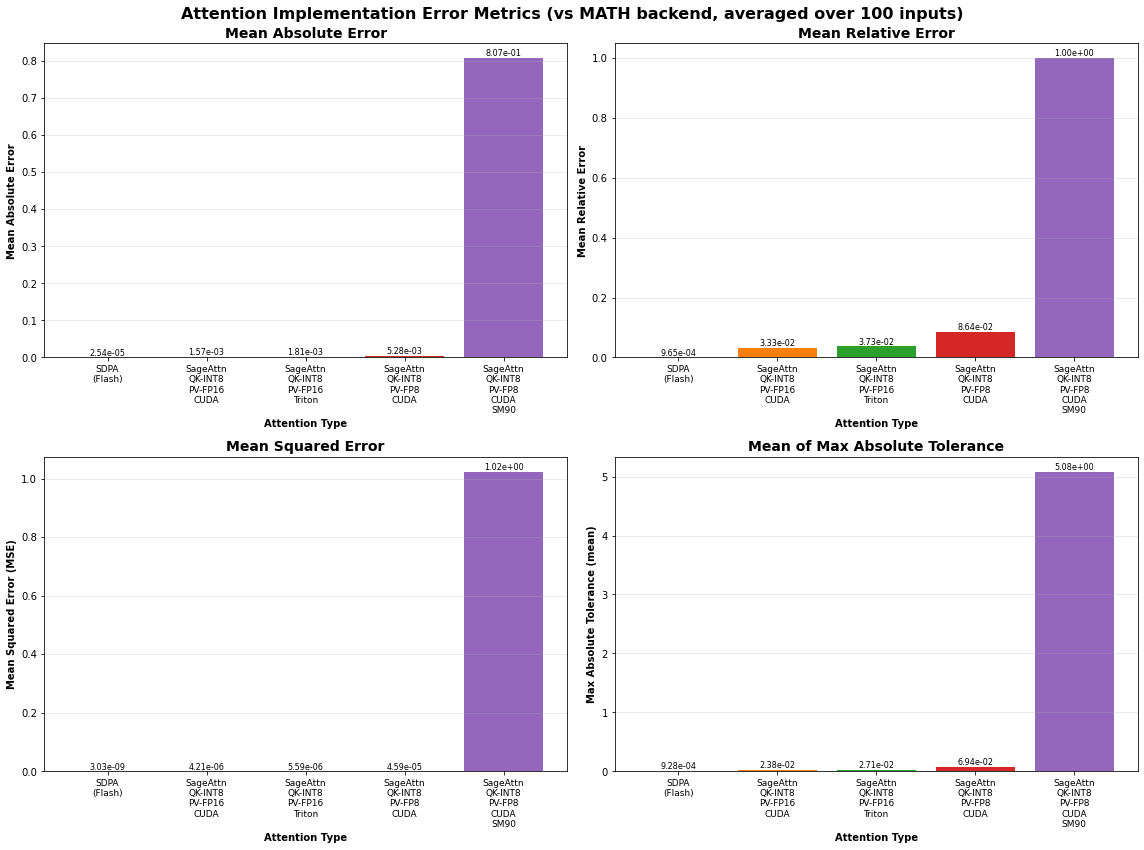

Barplots generated successfully!


In [5]:
# Create barplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Attention Implementation Error Metrics (vs MATH backend, averaged over 100 inputs)', 
             fontsize=16, fontweight='bold')

# Prepare data for plotting
names = list(mean_metrics.keys())
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Metric 1: Mean Absolute Error
ax1 = axes[0, 0]
mean_abs_errors = [mean_metrics[name]['mean_absolute_tolerance'] for name in names]
bars1 = ax1.bar(range(len(names)), mean_abs_errors, color=colors)
ax1.set_xlabel('Attention Type', fontweight='bold')
ax1.set_ylabel('Mean Absolute Error', fontweight='bold')
ax1.set_title('Mean Absolute Error', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(names)))
ax1.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax1.grid(axis='y', alpha=0.3)
# ax1.set_yscale('log')
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars1, mean_abs_errors)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 2: Mean Relative Error
ax2 = axes[0, 1]
mean_rel_errors = [mean_metrics[name]['mean_relative_tolerance'] for name in names]
bars2 = ax2.bar(range(len(names)), mean_rel_errors, color=colors)
ax2.set_xlabel('Attention Type', fontweight='bold')
ax2.set_ylabel('Mean Relative Error', fontweight='bold')
ax2.set_title('Mean Relative Error', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(names)))
ax2.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)
# ax2.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars2, mean_rel_errors)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 3: MSE
ax3 = axes[1, 0]
mse_values = [mean_metrics[name]['mse'] for name in names]
bars3 = ax3.bar(range(len(names)), mse_values, color=colors)
ax3.set_xlabel('Attention Type', fontweight='bold')
ax3.set_ylabel('Mean Squared Error (MSE)', fontweight='bold')
ax3.set_title('Mean Squared Error', fontsize=14, fontweight='bold')
ax3.set_xticks(range(len(names)))
ax3.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
# ax3.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars3, mse_values)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

# Metric 4: Max Absolute Tolerance
ax4 = axes[1, 1]
max_abs_tolerance = [mean_metrics[name]['max_absolute_tolerance'] for name in names]
bars4 = ax4.bar(range(len(names)), max_abs_tolerance, color=colors)
ax4.set_xlabel('Attention Type', fontweight='bold')
ax4.set_ylabel('Max Absolute Tolerance (mean)', fontweight='bold')
ax4.set_title('Mean of Max Absolute Tolerance', fontsize=14, fontweight='bold')
ax4.set_xticks(range(len(names)))
ax4.set_xticklabels([name.replace(' ', '\n') for name in names], rotation=0, ha='center', fontsize=9)
ax4.grid(axis='y', alpha=0.3)
# ax4.set_yscale('log')
for i, (bar, val) in enumerate(zip(bars4, max_abs_tolerance)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.2e}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Barplots generated successfully!")


In [6]:
# Create a summary comparison table
import pandas as pd

summary_data = []
for name, metrics in mean_metrics.items():
    summary_data.append({
        'Attention Type': name,
        'Mean Abs Error': f"{metrics['mean_absolute_tolerance']:.6e}",
        'Mean Rel Error': f"{metrics['mean_relative_tolerance']:.6e}",
        'MSE': f"{metrics['mse']:.6e}",
        'Max Abs Tolerance': f"{metrics['max_absolute_tolerance']:.6e}",
        'Max Rel Tolerance': f"{metrics['max_relative_tolerance']:.6e}",
    })

pd.DataFrame(summary_data)


,Attention Type,Mean Abs Error,Mean Rel Error,MSE,Max Abs Tolerance,Max Rel Tolerance
0,SDPA (Flash),2.535980e-05,9.653157e-04,3.025247e-09,9.277344e-04,1.964773e+00
1,SageAttn QK-INT8 PV-FP16 CUDA,1.567693e-03,3.326480e-02,4.209428e-06,2.383858e-02,1.999427e+00
2,SageAttn QK-INT8 PV-FP16 Triton,1.807868e-03,3.733505e-02,5.586522e-06,2.711311e-02,1.999377e+00
3,SageAttn QK-INT8 PV-FP8 CUDA,5.281397e-03,8.635315e-02,4.591901e-05,6.944824e-02,1.999887e+00
4,SageAttn QK-INT8 PV-FP8 CUDA SM90,8.070055e-01,9.999691e-01,1.023031e+00,5.081975e+00,2.000000e+00
